In [ ]:
from langchain_community.chat_models import ChatOllama
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict, List

# Initialize the LLM (Replace with your preferred model)
llm = ChatOllama(model="llama3.1", device="cuda", temperature=0)

# Predefined business plan sections
SECTIONS = [
    "Company Description",
    "Market Analysis",
    "Organization and Management",
    "Service or Product Line",
    "Marketing and Sales",
    "Funding Request",
    "Financial Projections",
    "Executive Summary"
]

# Questions for each section
QUESTIONS = {
    "Company Description": "Describe your business. What is its name, what problem does it solve, and what makes it unique?",
    "Market Analysis": "Who is your target audience, and who are your main competitors?",
    "Organization and Management": "What is your business structure, and who are the key members of your team?",
    "Service or Product Line": "What products or services do you offer, and how do they benefit customers?",
    "Marketing and Sales": "How will you attract and retain customers, and how will you generate sales?",
    "Funding Request": "How much funding do you need, and what will it be used for?",
    "Financial Projections": "What are your projected revenues, expenses, and break-even point?",
    "Executive Summary": "Summarize your business plan in a few sentences."
}

class BusinessPlanState(TypedDict):
    user_input: str
    responses: Dict[str, str]
    sections: List[str]
    current_section: int
    history: Dict[str, List[str]]  # Stores questions and answers

# LangGraph setup
class BusinessPlanBuilder:
    def __init__(self):
        graph = StateGraph(BusinessPlanState)
        
        # Add nodes for each section
        for section in SECTIONS:
            graph.add_node(section, self.ask_initial_question)

        # Add nodes for follow-up questions
        for section in SECTIONS:
            followup_node = f"{section} Followup"
            graph.add_node(followup_node, self.ask_followup_question)

            # Connect section nodes to their follow-up
            graph.add_edge(section, followup_node)

            # Connect follow-up nodes to the next section
            next_section = SECTIONS[SECTIONS.index(section) + 1] if section != "Executive Summary" else "Compile Plan"
            graph.add_edge(followup_node, next_section)

        # Add final compilation node
        graph.add_node("Compile Plan", self.compile_business_plan)
        graph.add_edge("Executive Summary Followup", "Compile Plan")
        graph.add_edge("Compile Plan", END)

        # Set entry point
        graph.set_entry_point("Company Description")
        self.graph = graph.compile()

    def invoke(self):
        """Start the structured business plan flow."""
        return self.graph.invoke({
            "user_input": "",
            "responses": {},
            "sections": SECTIONS,
            "current_section": 0,
            "history": {}
        })

    def input_handler(self, state: BusinessPlanState):        
        state["user_input"] = input().strip()

        if state["user_input"] == "exit":
            return END

        if state["user_input"] == "skip":
            state["current_section"] += 1
            if state["current_section"] >= len(state["sections"]):
                state["current_section"] = len(state["sections"]) - 1
            return state

        if state["user_input"] == "back":
            state["current_section"] -= 1
            if state["current_section"] < 0:
                state["current_section"] = 0
            return state

        return state

    def ask_initial_question(self, state: BusinessPlanState):
        section = state["sections"][state["current_section"]]
        question = QUESTIONS[section]

        print(f"\n{section} - {question}")
        state = self.input_handler(state)

        # Store response
        state["responses"][section] = state["user_input"]
        
        # Store Q&A in history
        if section not in state["history"]:
            state["history"][section] = []
        state["history"][section].append(f"Q: {question}\nA: {state['user_input']}\n")

        return state

    def ask_followup_question(self, state: BusinessPlanState):
        section = state["sections"][state["current_section"]]
        initial_response = state["responses"][section]

        followup_prompt = f"""Analyze this business plan response and identify any missing details:
        
        Question: {QUESTIONS[section]}
        Response: {initial_response}

        Create a follow-up question to fill any gaps and complete incomplete responses if the response does not answer all questions asked. Do not call it the follow-up question, mention "follow-up question at all", or use any kind of qualifiers or titles to label it as something similar. Only ask the question directly."""

        followup_question = llm.invoke(followup_prompt).content.strip()

        print(f"{followup_question}")
        state = self.input_handler(state)

        # Store follow-up response
        state["responses"][section] += f"\n\n{state['user_input']}"

        # Append to history
        state["history"][section].append(f"Q: {followup_question}\nA: {state['user_input']}")

        state["current_section"] += 1
        return state

    def compile_business_plan(self, state: BusinessPlanState):
        
        # Assemble full Q&A history
        full_qa = "\n\n".join(["\n".join(qas) for qas in state["history"].values()])

        # Use LLM to refine the business plan
        prompt = f"""Based on the following structured questions and answers, generate a detailed, professional, and well-formatted business plan. Ensure that it follows this structure:

        1. Executive Summary
        2. Company Description
        3. Market Analysis
        4. Organization and Management
        5. Service or Product Line
        6. Marketing and Sales
        7. Funding Request
        8. Financial Projections

        Here is the collected information:

        {full_qa}

        Do not fabricate any information or make assumptions. Make sure to only use the provided information to generate the business plan.
        Now, craft a professional business plan with clear, concise, and structured content.
        """

        refined_business_plan = llm.invoke(prompt).content.strip()
        disclaimer = "\n\nPLEASE NOTE: The generated business plan is a starting point and may require further refinement and correction."
        refined_business_plan += disclaimer

        # Store final business plan in state
        state["responses"]["Final Plan"] = refined_business_plan

        print("\n--- Your Complete Business Plan ---\n")
        print(refined_business_plan)

        return state


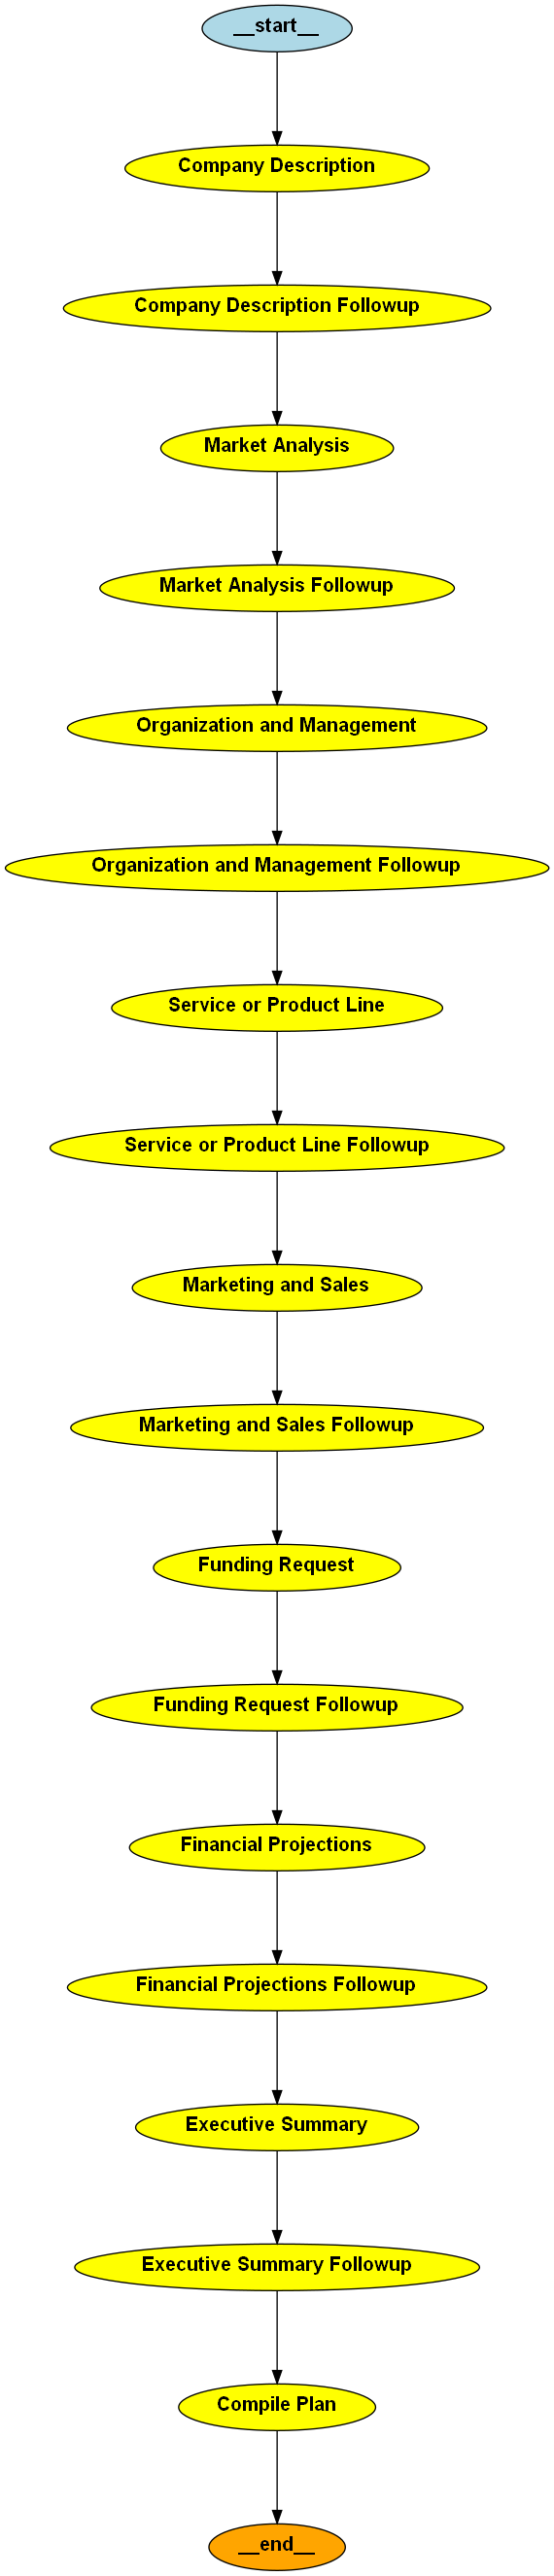

In [26]:
from IPython.display import Image

abot = BusinessPlanBuilder()
Image(abot.graph.get_graph().draw_png())

In [23]:
builder = BusinessPlanBuilder()
result = builder.invoke()


Company Description - Describe your business. What is its name, what problem does it solve, and what makes it unique?
What specific types of small home repairs does EasyFix specialize in fixing, and what is the typical scope of work for a single visit?

Market Analysis - Who is your target audience, and who are your main competitors?
What specific characteristics or demographics define your target audience (e.g., age range, income level, geographic location), and how do you plan to reach them with your services?

Organization and Management - What is your business structure, and who are the key members of your team?
What specific roles will you have within your business structure (e.g., CEO, operations manager, marketing specialist), and what are their respective responsibilities?

Service or Product Line - What products or services do you offer, and how do they benefit customers?
What specific types of small home repairs do you offer (e.g., plumbing, electrical work, carpentry), and 

In [24]:
for section in result["history"]:
    print(f"\n--- {section} ---\n")
    for qa in result["history"][section]:
        print(qa)


--- Company Description ---

Q: Describe your business. What is its name, what problem does it solve, and what makes it unique?
A: My business is called "EasyFix," and it helps people fix small home repairs quickly. What's unique is that we come to you fast and don't charge a lot.
Agent: What specific types of small home repairs does EasyFix specialize in fixing, and what is the typical scope of work for a single visit?
User: We specialize in things like leaky faucets, broken door handles, and fixing small holes in walls. A typical visit would be fixing one or two of these kinds of problems.

--- Market Analysis ---

Q: Who is your target audience, and who are your main competitors?
A: My target audience is homeowners or renters who need quick fixes, and my competitors are local handymen and big services like HomeAdvisor.
Agent: What specific characteristics or demographics define your target audience (e.g., age range, income level, geographic location), and how do you plan to reach t

In [25]:
print(result["responses"]["Final Plan"])

**EasyFix Business Plan**

**Executive Summary**

EasyFix is a small home repair service that specializes in quick fixes for homeowners or renters. Our mission is to provide affordable, fast, and reliable solutions for common household problems such as leaky faucets, broken door handles, and small holes in walls. With a focus on customer satisfaction and a personal touch, we aim to become the go-to service for quick home repairs.

**Company Description**

EasyFix is a sole proprietorship owned and operated by [Your Name]. Our business structure will be small, with you running things and possibly hiring a couple of handymen to assist with repairs. We will operate in the city, targeting homeowners or renters aged 30-50, middle-income individuals.

**Market Analysis**

Our target audience is homeowners or renters who need quick fixes for common household problems. According to our research, this demographic is likely to be people in their 30s to 50s, living in the city, and having a moder